# Xenium Human Lung Preview: Downstream Analysis

This notebook continues from the preprocessed `AnnData` object generated in **Notebook 1 (Ingestion & Matrix Construction)**.  
Here, we perform all **downstream analysis** steps on the Xenium Human Lung (FFPE, non-diseased) dataset.

**Workflow steps covered in this notebook:**
1. **Load processed data** (`adata_raw.h5ad`) created in Notebook 1.  
2. **Quality control (QC) filtering** using data-driven thresholds.  
3. **Normalization and transformation** (total-count scaling, log1p).  
4. **Feature selection**: identify highly variable genes (HVGs).  
5. **Dimensionality reduction** with PCA.  
6. **Clustering and visualization** (neighbor graph, UMAP, Leiden).  
7. **Spatial visualizations**: density maps, cluster overlays, feature expression.  
8. **Marker detection** with Wilcoxon tests and visualization (dotplots, heatmaps).  
9. **Spatial neighborhood analysis** using Squidpy (enrichment, connectivity).  
10. **Export outputs**: figures and final `.h5ad` file for sharing or further work.

> **Note:** Make sure `adata_raw.h5ad` and `qc_metrics.csv` exist in your `results/` folder before running this notebook.


## Environment Setup and Imports

In this section we load all required Python packages for the downstream analysis.  
These include:

- **Core scientific stack:** `numpy`, `pandas`, `matplotlib`, `seaborn`  
- **Single-cell analysis:** `scanpy`, `anndata`  
- **Spatial analysis:** `squidpy`  
- **Sparse and data handling:** `scipy.sparse`, `pyarrow`  

We also configure:
- A fixed random seed for reproducibility.  
- Project paths for data, results, and figures.  
- Global plotting defaults for consistent visualization style.


In [1]:
# =========================
# Standard library imports
# =========================
from __future__ import annotations
import os
import sys
from datetime import datetime
from pathlib import Path

# ======================
# Third-party libraries
# ======================
import anndata as ad                  # core data structure
import matplotlib as mpl              # plotting engine
import matplotlib.pyplot as plt       # main plotting API
import numpy as np                    # numerics
import pandas as pd                   # tabular data
import scanpy as sc                   # single-cell analysis
import seaborn as sns                 # styled plots
import squidpy as sq                  # spatial transcriptomics
from matplotlib.colors import LogNorm, PowerNorm  # color scaling
from scipy.sparse import issparse     # check sparse/dense arrays

# =====================================
# Set global seed for reproducibility
# =====================================
import random
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

# =====================================
# Global dark theme
# =====================================

mpl.rcParams.update({
    "figure.figsize": (8, 8),
    "figure.facecolor": "black",
    "savefig.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#666666",
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.grid": True,           # light grid like the HTML report
})


/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  retur

## Load processed AnnData

Load the preprocessed dataset (`adata_raw.h5ad`) created in Notebook 1 and set up paths for results and figures.


In [2]:
# Paths (adapt to your repo structure)
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parents[0]

DATA = ROOT / "data"
RESULTS = ROOT / "results"
FIGS = RESULTS / "figures"

# Load AnnData produced in Notebook 1
adata = ad.read_h5ad(RESULTS / "adata_raw.h5ad")

print(f"[LOAD] AnnData with {adata.n_obs:,} cells × {adata.n_vars:,} genes")


[LOAD] AnnData with 295,883 cells × 392 genes


## QC visualizations

Generate three plots to assess cell quality:

1. **Histogram of total counts per cell** – Shows distribution of read counts with x-axis labels every 50 units.  
2. **Histogram of detected genes per cell** – Displays distribution of gene counts with labels every 50 units.  
3. **Scatter plot of counts vs. genes** – Compares total counts and detected genes per cell to identify outliers or trends.

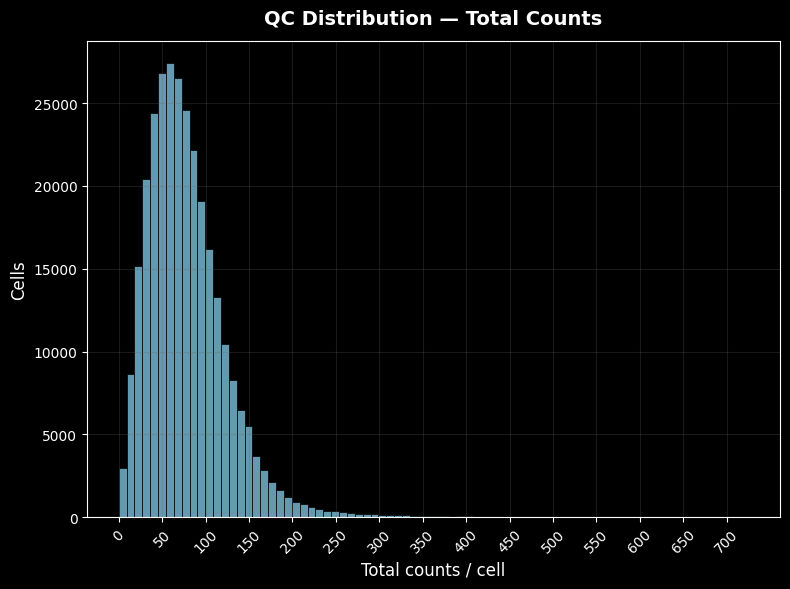

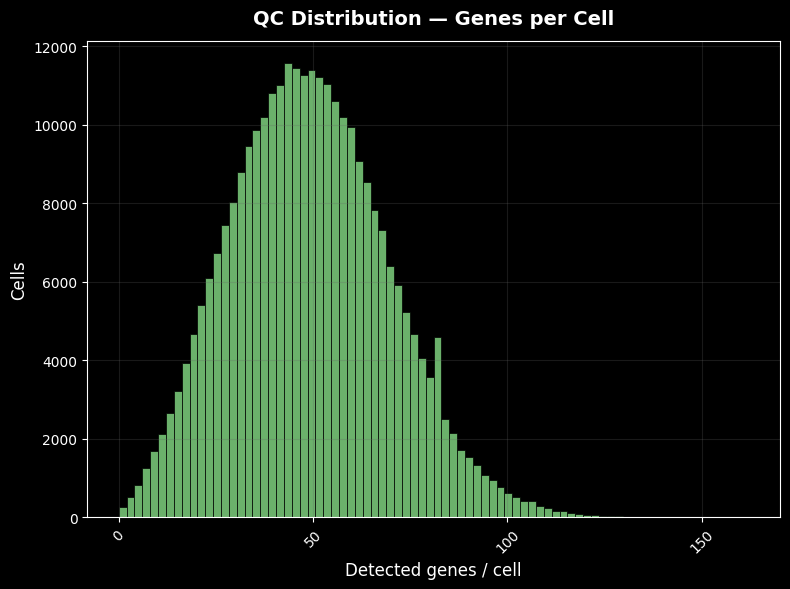

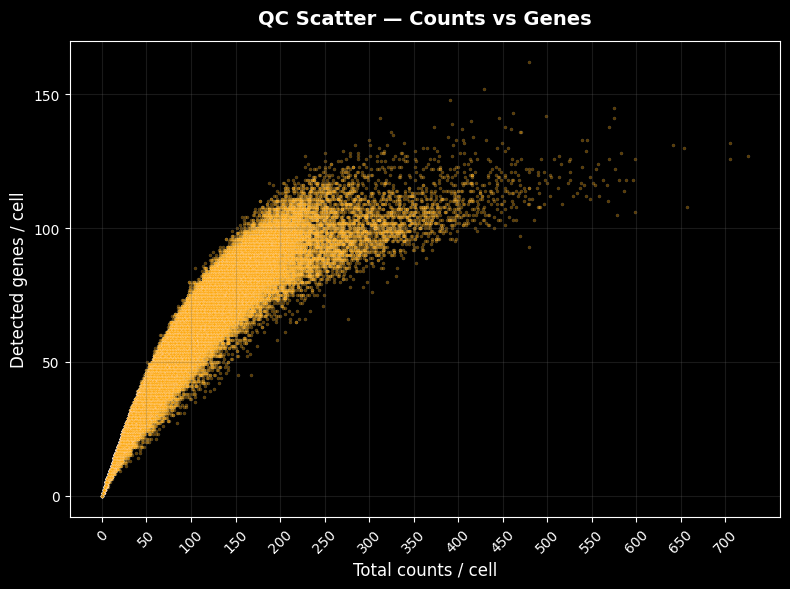

In [3]:
# --- Title helper ---
def set_plot_title(ax, title: str, fontsize: int = 14, color: str = "white"):
    ax.set_title(title, fontsize=fontsize, weight="bold", pad=12, color=color)

# -------- Figure 1 — QC distribution: total counts --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(adata.obs["total_counts"], bins=80, ax=ax, color="skyblue")
ax.set_xlabel("Total counts / cell", fontsize=12, color="white")
ax.set_ylabel("Cells", fontsize=12, color="white")
set_plot_title(ax, "QC Distribution — Total Counts")

max_val = int(adata.obs["total_counts"].max())
ax.set_xticks(np.arange(0, max_val + 1, 50))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_color("white")
for label in ax.get_yticklabels():
    label.set_color("white")

fig.tight_layout()
fig.savefig(FIGS / "01_qc_hist_total_counts.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# -------- Figure 2 — QC distribution: genes detected --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(adata.obs["n_genes_by_counts"], bins=80, ax=ax, color="lightgreen")
ax.set_xlabel("Detected genes / cell", fontsize=12, color="white")
ax.set_ylabel("Cells", fontsize=12, color="white")
set_plot_title(ax, "QC Distribution — Genes per Cell")

max_val = int(adata.obs["n_genes_by_counts"].max())
ax.set_xticks(np.arange(0, max_val + 1, 50))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_color("white")
for label in ax.get_yticklabels():
    label.set_color("white")

fig.tight_layout()
fig.savefig(FIGS / "02_qc_hist_genes_per_cell.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# -------- Figure 3 — QC scatter: counts vs genes --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x="total_counts", y="n_genes_by_counts", s=5, alpha=0.35, data=adata.obs, ax=ax, color="orange"
)
ax.set_xlabel("Total counts / cell", fontsize=12, color="white")
ax.set_ylabel("Detected genes / cell", fontsize=12, color="white")
set_plot_title(ax, "QC Scatter — Counts vs Genes")

max_x = int(adata.obs["total_counts"].max())
max_y = int(adata.obs["n_genes_by_counts"].max())
ax.set_xticks(np.arange(0, max_x + 1, 50))
ax.set_yticks(np.arange(0, max_y + 1, 50))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_color("white")
for label in ax.get_yticklabels():
    label.set_color("white")

fig.tight_layout()
fig.savefig(FIGS / "03_qc_scatter_counts_vs_genes.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)


## Adaptive QC Filtering

To retain high-quality cells, we apply **data-driven thresholds** based on the 1% quantile of the distributions:

- **Minimum counts per cell**: keep cells with at least the higher of (1% quantile, 50).  
- **Minimum genes per cell**: keep cells with at least the higher of (1% quantile, 15).  

If this strict filter discards all cells (e.g., for very sparse panels), a **fallback threshold** of `min_counts=10` and `min_genes=5` is applied.

After filtering, we create a new `AnnData` object and plot a **spatial density map** to visualize the retained cells.


[QC] min_counts=50.0, min_genes=15.0 → keep 212,528/295883
[QC] post-filter shape: (212528, 392)


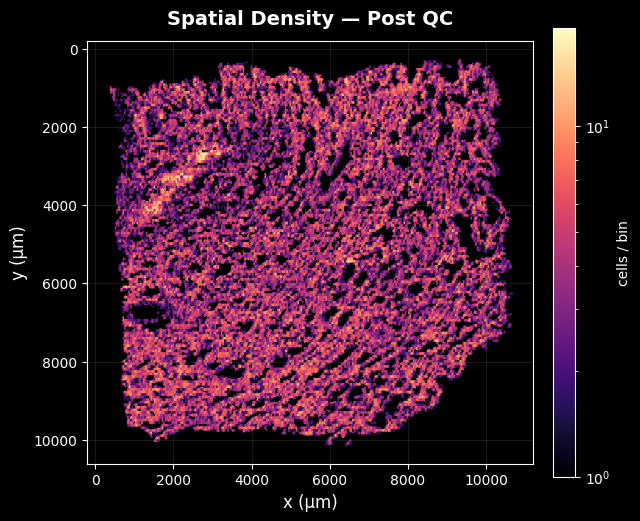

In [4]:
# -------------------------
# QC thresholds & filtering
# -------------------------
cnt = adata.obs["total_counts"]
ng  = adata.obs["n_genes_by_counts"]

min_counts = max(np.quantile(cnt, 0.01), 50)   # ≥ 1st percentile or 50
min_genes  = max(np.quantile(ng,  0.01), 15)   # ≥ 1st percentile or 15

keep = (cnt >= min_counts) & (ng >= min_genes)
n_keep = int(keep.sum())
print(f"[QC] min_counts={min_counts:.1f}, min_genes={min_genes:.1f} → keep {n_keep:,}/{adata.n_obs}")

if n_keep == 0:
    # Fallback if the panel is very sparse or distributions are odd
    min_counts, min_genes = 10, 5
    keep = (cnt >= min_counts) & (ng >= min_genes)
    n_keep = int(keep.sum())
    print(f"[QC][fallback] min_counts={min_counts}, min_genes={min_genes} → keep {n_keep:,}/{adata.n_obs}")
    assert n_keep > 0, "QC still yielded 0 cells; inspect distributions."

adata = adata[keep].copy()
print(f"[QC] post-filter shape: {adata.shape}")

# -------------------------
# Helper for plot titles
# -------------------------
def set_plot_title(ax, title: str, fontsize: int = 14, color: str = "white"):
    ax.set_title(title, fontsize=fontsize, weight="bold", pad=12, color=color)

# -----------------------------------------
# Figure 4 — Spatial density (post-QC, log)
# -----------------------------------------
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

fig, ax = plt.subplots(figsize=(6.5, 6.5))

# hexbin with log bins looks great on dark backgrounds
hb = ax.hexbin(x, y, gridsize=260, bins='log', mincnt=1, cmap="magma")

# axes formatting
ax.invert_yaxis()
ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)", fontsize=12, color="white")
ax.set_ylabel("y (µm)", fontsize=12, color="white")
set_plot_title(ax, "Spatial Density — Post QC")

# colorbar formatting (white ticks/frame for dark theme)
cb = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("cells / bin", color="white")
cb.ax.tick_params(colors="white")
cb.outline.set_edgecolor("white")

fig.tight_layout()
fig.savefig(FIGS / "04_spatial_density_post_qc.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)


## Normalization, Feature Selection, and Clustering

We now process the filtered dataset through the standard Scanpy pipeline:

1. **Normalization & log transform**  
   - Normalize each cell to a total of 10,000 counts.  
   - Apply log1p transformation to stabilize variance.  

2. **Highly variable genes (HVGs)**  
   - With small targeted panels, keep all genes or up to 3,000.  
   - Subset the matrix to HVGs for efficient analysis.  

3. **Principal Component Analysis (PCA)**  
   - Reduce dimensionality using up to 30 PCs (or fewer if the panel is small).  
   - Generate a scree plot to visualize explained variance.  

4. **Neighborhood graph, UMAP, and Leiden clustering**  
   - Build a k-nearest neighbor graph (15 neighbors, 12 PCs).  
   - Embed the data in 2D with UMAP (`min_dist=0.35`, `spread=1.0`).  
   - Perform community detection with Leiden clustering (`resolution=0.5`).  

This sets up the dataset for cluster-based and spatial analyses.


## PCA Scree & Elbow Plot

This code performs PCA on the normalized single-cell data and visualizes:

- **Per-PC variance (bars + line):** how much variance each principal component explains.  
- **Cumulative variance (green line):** total variance explained as PCs are added.  
- **Elbow point (yellow marker):** automatically detected using curvature (≈ PC5 here).  

The elbow gives a *lower bound* for the number of PCs to keep. In practice, scRNA-seq analyses usually use more PCs since biological signals are spread across multiple dimensions. The scree plot helps balance capturing meaningful variance while avoiding noise.



[PCA] elbow≈PC5 (cumulative variance: 0.141)


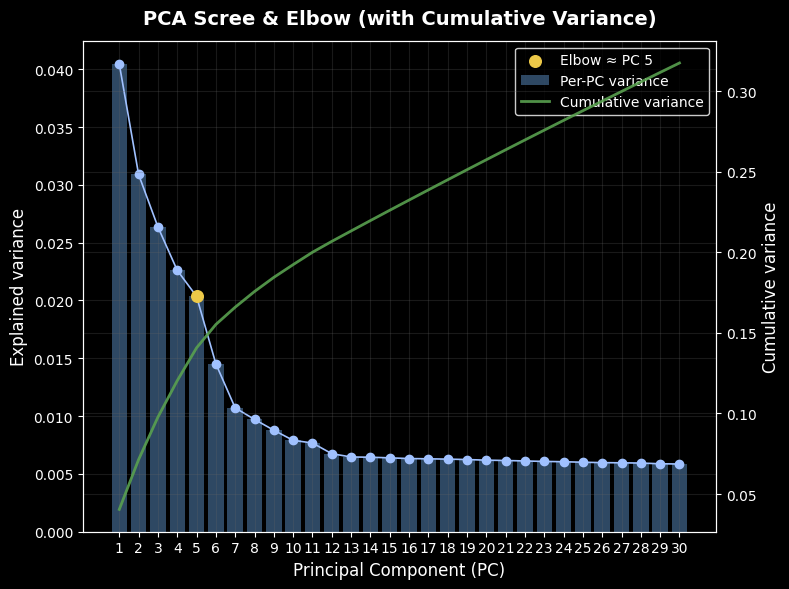

In [5]:
# --- Normalization & PCA ---
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(3000, adata.n_vars), subset=True)

n_comps = min(30, max(2, adata.n_vars - 1))
sc.pp.pca(adata, n_comps=n_comps)

# --- Scree data ---
vr  = np.asarray(adata.uns["pca"]["variance_ratio"])   # per-PC variance explained
pcs = np.arange(1, len(vr) + 1)
cum = np.cumsum(vr)

# --- Simple elbow heuristic (curvature) ---
g1 = np.gradient(vr)
g2 = np.gradient(g1)
elbow_idx = int(np.argmax(-g2))  # zero-based
elbow_pc = pcs[elbow_idx]
cum_at_elbow = float(cum[elbow_idx])
print(f"[PCA] elbow≈PC{elbow_pc} (cumulative variance: {cum_at_elbow:.3f})")

# --- Plot (dark-theme friendly, clean) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Per-PC variance: bars + thin line
ax.bar(pcs, vr, alpha=0.6, width=0.8, label="Per-PC variance", color="#4E79A7")
ax.plot(pcs, vr, marker="o", lw=1.2, color="#A0C1FF")

# Elbow marker
ax.scatter([elbow_pc], [vr[elbow_idx]], s=70, color="#EDC948", zorder=5,
           label=f"Elbow ≈ PC {elbow_pc}")

# Cumulative variance on secondary axis
ax2 = ax.twinx()
ax2.plot(pcs, cum, lw=2.0, alpha=0.9, color="#59A14F", label="Cumulative variance")

# Labels, ticks, styling
ax.set_xlabel("Principal Component (PC)", fontsize=12, color="white")
ax.set_ylabel("Explained variance", fontsize=12, color="white")
ax2.set_ylabel("Cumulative variance", fontsize=12, color="white")
ax.set_xticks(pcs)

for t in ax.get_xticklabels():
    t.set_color("white")
for t in ax.get_yticklabels():
    t.set_color("white")
for t in ax2.get_yticklabels():
    t.set_color("white")

# Title
ax.set_title("PCA Scree & Elbow (with Cumulative Variance)",
             fontsize=14, weight="bold", color="white", pad=12)

# Legend (combine both axes)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right", frameon=True)
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
for txt in leg.get_texts():
    txt.set_color("white")

fig.tight_layout()
fig.savefig(FIGS / "05_pca_scree.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

### Neighbors + UMAP + Leiden (12 PCs)

We build the neighborhood graph using **12 principal components**, then compute a 2D UMAP embedding for visualization. Finally, clustering is performed with the **Leiden algorithm** at resolution 0.5, which assigns cells into communities (stored in `adata.obs["leiden"]`). This step captures both the local structure of the data and the broader cellular diversity.

In [14]:
# Neighbors + UMAP + Leiden (12 PCs )
n_pcs = min(30, adata.obsm["X_pca"].shape[1])
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.35, spread=1.0, random_state=0)
# 2) Leiden with igraph backend (explicit + future-proof)
sc.tl.leiden(
    adata,
    resolution=0.5,
    flavor="igraph",     # use igraph backend
    n_iterations=2,      # Scanpy’s suggested future default
    directed=False,      # typical for scRNA/Spatial KNN graphs
    random_state=0       # for reproducibility of ties
)

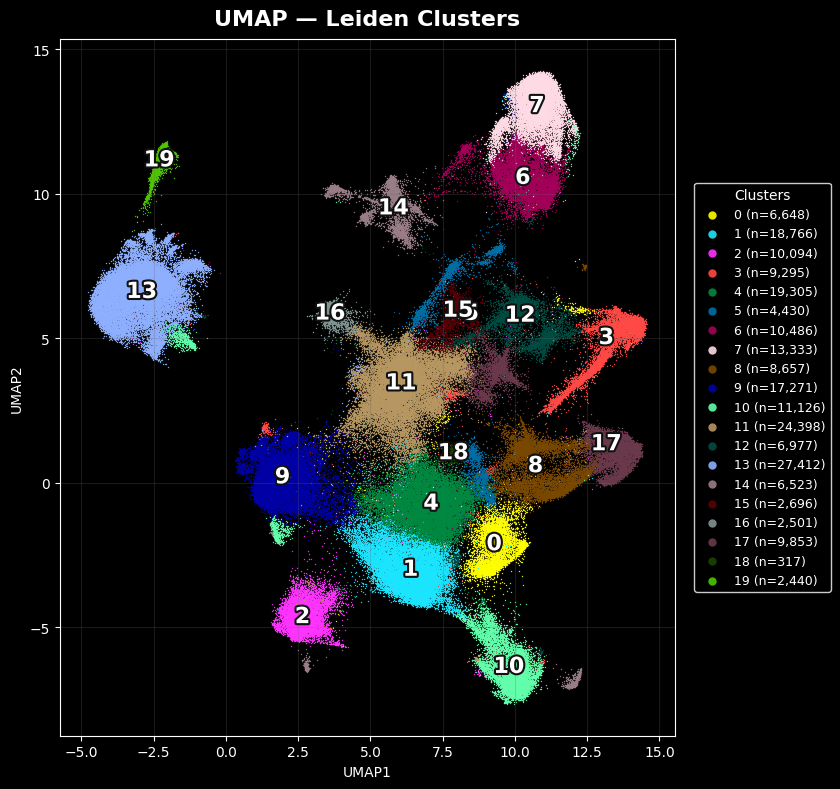

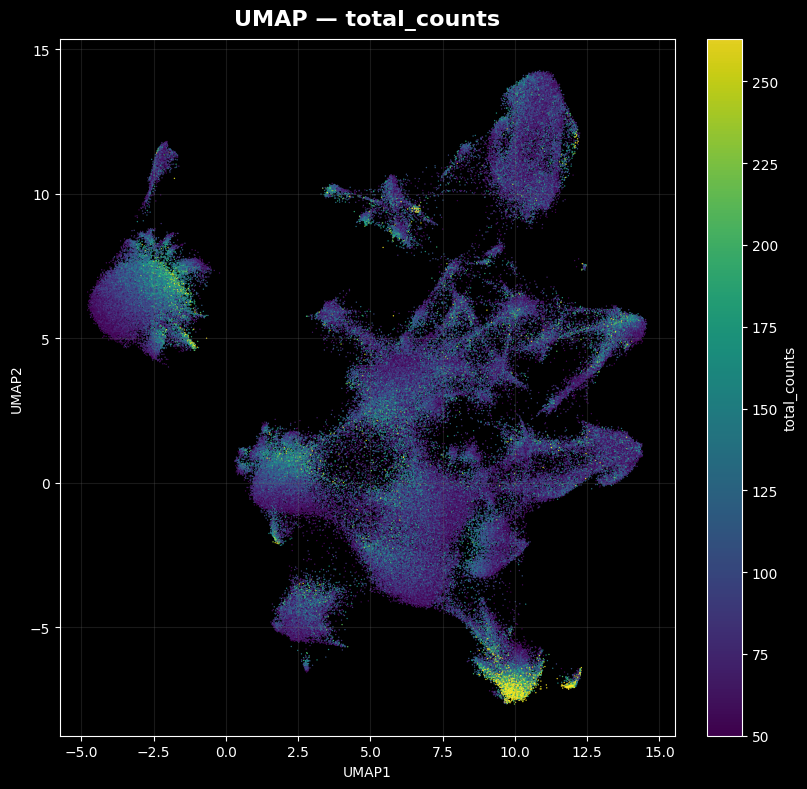

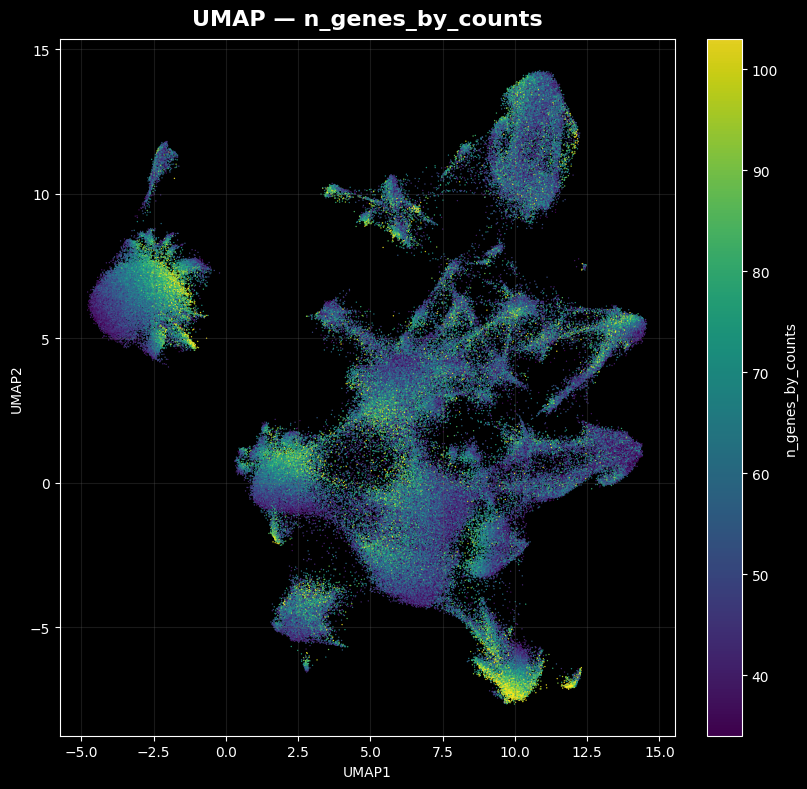

In [13]:
# -----------------------------
# UMAP coordinates (once)
# -----------------------------
XY = adata.obsm["X_umap"]
x, y = XY[:, 0], XY[:, 1]

# -----------------------------
# Helper: set a bold white title
# -----------------------------
def set_title(ax, text, fs=16):
    ax.set_title(text, fontsize=fs, weight="bold", color="white", pad=10)

# ============================================
# 1) UMAP — Leiden clusters (with medoid text)
# ============================================
cats = adata.obs["leiden"].astype("category")
cats = cats.cat.remove_unused_categories()
palette = sc.plotting.palettes.default_102[: len(cats.cat.categories)]

fig, ax = plt.subplots(figsize=(9.8, 8))  # a bit wider for side legend

# Plot each cluster separately (crisper legend markers on export)
for k, cat in enumerate(cats.cat.categories):
    idx = (cats.values == cat)
    ax.scatter(
        x[idx], y[idx],
        s=1.0, c=[palette[k]], lw=0, alpha=0.9,
        rasterized=True, label=f"{cat} (n={idx.sum():,})"
    )

# Label cluster medoids (median in UMAP space)
centroids = (
    pd.DataFrame({"x": x, "y": y, "c": cats.values})
    .groupby("c", observed=True)[["x", "y"]]
    .median()
)
for lab, (cx, cy) in centroids.iterrows():
    ax.text(
        cx, cy, str(lab), ha="center", va="center",
        fontsize=16, fontweight="bold", color="white",
        path_effects=[mpl.patheffects.withStroke(linewidth=3, foreground="#111")]
    )

ax.set_xlabel("UMAP1", color="white")
ax.set_ylabel("UMAP2", color="white")
ax.set_aspect("equal", "box")
set_title(ax, "UMAP — Leiden Clusters")

# Legend outside on the right
lines, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    lines, labels, title="Clusters",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, fontsize=9, markerscale=6/1.0, borderaxespad=0.6
)
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts(): t.set_color("white")

fig.tight_layout()
fig.savefig(FIGS / "06_umap_leiden.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close(fig)

# =========================================================
# 2) UMAP — continuous overlays (QC covariates, consistent)
# =========================================================
def umap_continuous(values, title, out_path, cmap="viridis"):
    """Plot UMAP colored by a continuous covariate with 1–99% clipping."""
    vals = np.asarray(values, dtype=float)
    vmin, vmax = np.nanpercentile(vals, [1, 99])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(9.0, 8.0))
    sca = ax.scatter(
        x, y, c=vals, s=1.0, cmap=cmap, norm=norm,
        lw=0, alpha=0.9, rasterized=True
    )
    ax.set_xlabel("UMAP1", color="white")
    ax.set_ylabel("UMAP2", color="white")
    ax.set_aspect("equal", "box")
    set_title(ax, f"UMAP — {title}")

    cb = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.04)
    cb.outline.set_edgecolor("white")
    cb.ax.tick_params(labelsize=10, colors="white")
    cb.set_label(title, color="white")

    fig.tight_layout()
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Call for QC covariates
umap_continuous(adata.obs["total_counts"],       "total_counts",       FIGS / "07_umap_total_counts.png")
umap_continuous(adata.obs["n_genes_by_counts"],  "n_genes_by_counts",  FIGS / "07_umap_n_genes_by_counts.png")


### Spatial Visualization

We generate three complementary spatial plots to interpret cell clustering and gene expression in tissue context:

- **Figure 8 — Spatial Leiden Clusters**  
  Each cell is placed at its spatial coordinates and colored by Leiden cluster. Cluster IDs are also annotated at their median positions, helping to visualize the spatial organization of distinct cell populations.

- **Figure 9 — Spatial Density Map**  
  Cells are binned using a hexagonal grid, with counts shown on a log scale. This highlights regions of high and low cell density, offering a global view of tissue structure after QC filtering.

- **Figure 10 — Spatial Feature Map (Single Gene)**  
  A selected gene (default: the first highly variable gene) is plotted across all spatial coordinates. Expression levels are color-coded with robust scaling, making it easier to detect local enrichment patterns even for lowly expressed genes.

Together, these plots connect **clustering results** with **spatial distribution** and **molecular features**, enabling biological interpretation of tissue architecture.


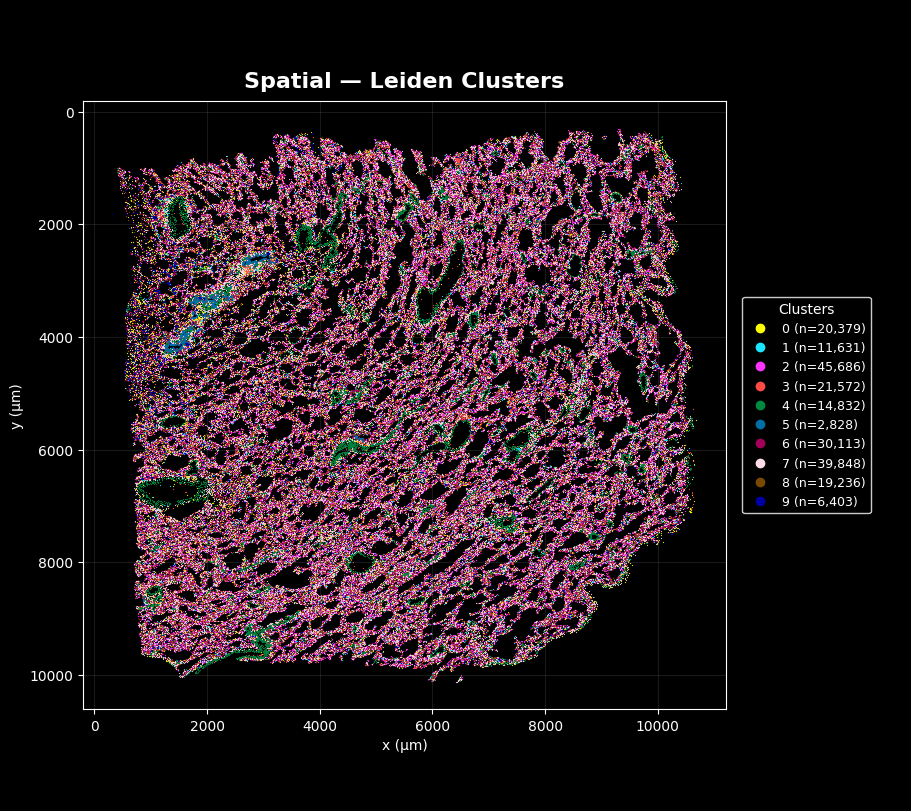

In [8]:
# -------------------------------------------------
# Spatial coordinates (once)
# -------------------------------------------------
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

# Fallback if the title helper isn't defined yet
try:
    set_title
except NameError:
    def set_title(ax, text, fs=16):
        ax.set_title(text, fontsize=fs, weight="bold", color="white", pad=10)

# ===============================================
# Figure 08 — Spatial: Leiden clusters (compact)
# ===============================================
from matplotlib.lines import Line2D

# Data & palette
cats = adata.obs["leiden"].astype("category").cat.remove_unused_categories()
codes = cats.cat.codes.to_numpy()
labels_cat = list(cats.cat.categories)
palette = sc.plotting.palettes.default_102[: len(labels_cat)]
x, y = adata.obsm["spatial"][:, 0], adata.obsm["spatial"][:, 1]

# Figure with a dedicated legend column
fig = plt.figure(figsize=(9.0, 8.0), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.26])  # right column = legend
ax = fig.add_subplot(gs[0, 0]); lg = fig.add_subplot(gs[0, 1]); lg.axis("off")

# Scatter per cluster
for k, col in enumerate(palette):
    m = (codes == k)
    if m.any():
        ax.scatter(x[m], y[m], s=0.8, c=[col], lw=0, alpha=0.9, rasterized=True)

# Axes styling
ax.invert_yaxis(); ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)", color="white"); ax.set_ylabel("y (µm)", color="white")
ax.set_title("Spatial — Leiden Clusters", fontsize=16, weight="bold", color="white", pad=10)

# Legend (outside, right)
counts = [int((codes == k).sum()) for k in range(len(labels_cat))]
labels = [f"{lab} (n={cnt:,})" for lab, cnt in zip(labels_cat, counts)]
proxies = [Line2D([0],[0], marker="o", lw=0, markersize=6,
                  markerfacecolor=palette[k], markeredgecolor=palette[k])
           for k in range(len(labels_cat))]
leg = lg.legend(proxies, labels, title="Clusters", loc="center left",
                frameon=True, fontsize=9, borderaxespad=0.6)
lg.set_facecolor("black")
leg.get_frame().set_facecolor("black"); leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts(): t.set_color("white")

fig.savefig(FIGS / "08_spatial_leiden.png", dpi=600, bbox_inches="tight")
plt.show(); plt.close(fig)

[Epithelial] using 5/13 markers; missing: ABCA3, CAV1, MUC5AC, SCGB1A1, SFTPA1, SFTPA2, SFTPC, SLC34A2
[Endothelial] using 6/9 markers; missing: EDNRB, EMCN, PECAM1
[Stromal] using 5/12 markers; missing: ACTA2, COL1A1, COL1A2, COL3A1, DCN, LUM, TAGLN
[Immune] using 10/16 markers; missing: GNLY, LYZ, MRC1, MS4A7, PTPRC, TRAC


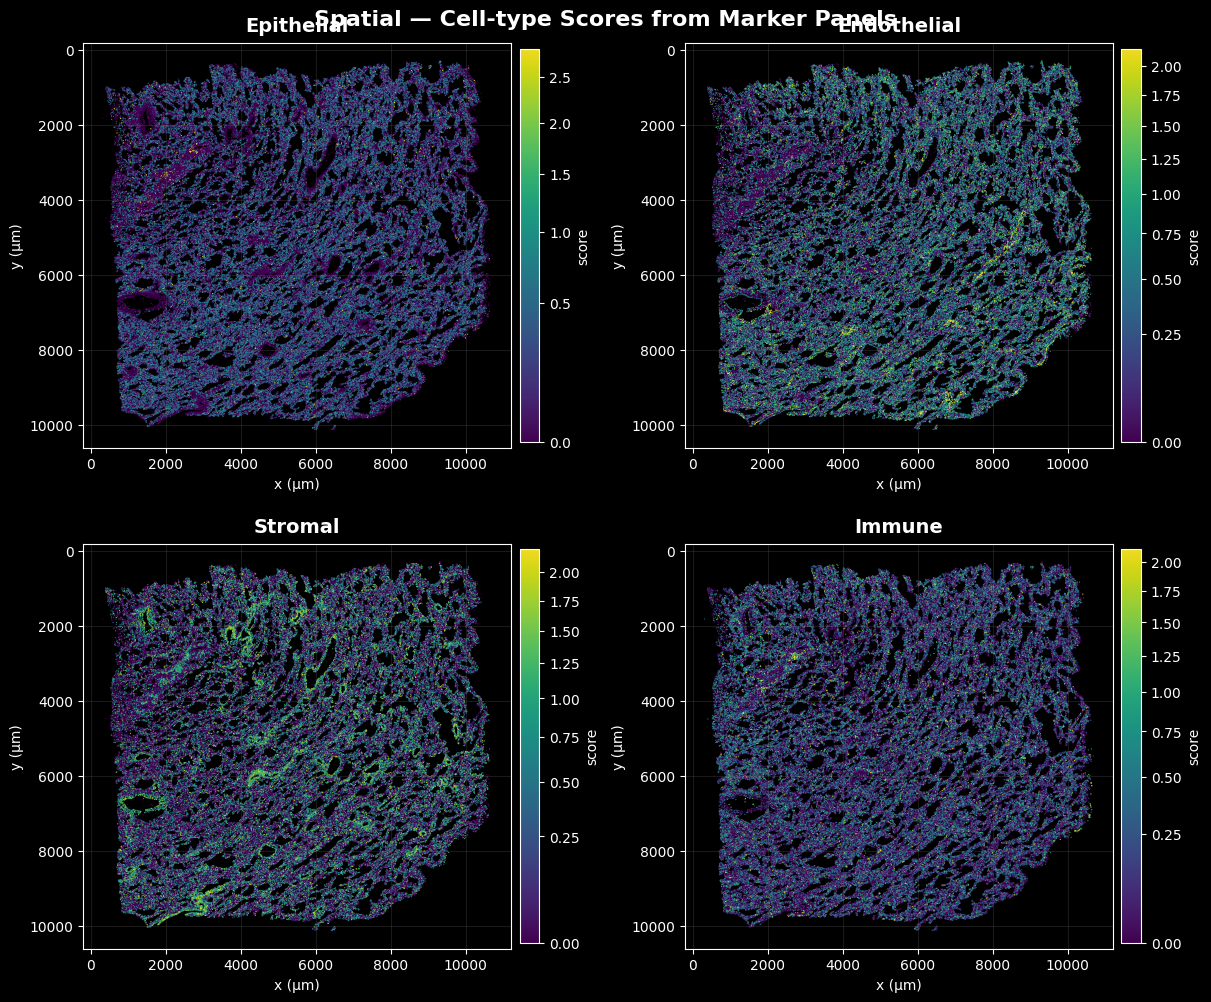

In [9]:
# ===========================================================
# Figure 12 — Spatial: cell-type scores (2×2) from marker sets
# ===========================================================
from scipy.sparse import issparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, PowerNorm

# --- Marker sets (curated) ---
markers = {
    "Epithelial": [
        # AT1
        "AGER","PDPN","CAV1",
        # AT2
        "SFTPC","SFTPA1","SFTPA2","SLC34A2","ABCA3",
        # Airway support
        "KRT5","TP63","SCGB1A1","MUC5AC","MUC5B",
    ],
    "Endothelial": [
        # pan-vascular
        "PECAM1","CLDN5","VWF","KDR","EMCN",
        # alveolar capillary/aerocyte
        "CA4","EDNRB",
        # lymphatic
        "LYVE1","PROX1",
    ],
    "Stromal": [
        # fibroblasts
        "COL1A1","COL1A2","COL3A1","LUM","DCN","PDGFRA",
        # smooth muscle / myofibroblast
        "ACTA2","TAGLN","MYH11",
        # pericytes
        "PDGFRB","RGS5","CSPG4",
    ],
    "Immune": [
        # pan-immune
        "PTPRC",
        # T cells
        "CD3D","CD3E","TRAC","CD4","CD8A",
        # B / Plasma
        "MS4A1","CD79A","MZB1",
        # Myeloid / Macrophage
        "MRC1","MARCO","LYZ","MS4A7",
        # NK
        "NKG7","GNLY","KLRD1",
    ],
}

# --- Data sources ---
XY = adata.obsm["spatial"]
x, y = XY[:, 0], XY[:, 1]

# We'll score on the current adata.X (normalized/log1p from your pipeline)
X = adata.X
if issparse(X):
    X = X.tocsr()

# Utility: z-score each selected gene across cells and average (ignore NaNs)
def gene_scores_from_panel(panel):
    present = [g for g in panel if g in adata.var_names]
    missing = sorted(set(panel) - set(present))
    if len(present) == 0:
        return np.zeros(adata.n_obs), present, missing

    # extract expression matrix for markers (cells x genes)
    idx = adata.var_names.get_indexer(present)
    M = X[:, idx] if issparse(X) else X[:, idx]

    # to dense (marker subset is small; safe)
    M = M.toarray() if issparse(M) else np.asarray(M)

    # z-score per gene across cells (add tiny eps to std)
    mu = np.nanmean(M, axis=0)
    sd = np.nanstd(M, axis=0)
    sd[sd < 1e-8] = 1e-8
    Z = (M - mu) / sd

    # mean z across markers (ignore NaNs)
    score = np.nanmean(Z, axis=1)

    # clamp low tail to 0 for nicer PowerNorm on dark bg
    floor = np.nanpercentile(score, 1)
    score = score - floor
    score[score < 0] = 0.0

    return score, present, missing

# Compute scores and keep some accounting
group_names = ["Epithelial", "Endothelial", "Stromal", "Immune"]
scores = []
used = {}
miss = {}

for g in group_names:
    scv, present, missing = gene_scores_from_panel(markers[g])
    scores.append(scv)
    used[g] = present
    miss[g] = missing
    print(f"[{g}] using {len(present)}/{len(markers[g])} markers; missing: {', '.join(missing) if missing else '—'}")

# --- Plot 2×2 spatial maps (dark-theme friendly) ---
fig, axes = plt.subplots(2, 2, figsize=(12.0, 10.0), constrained_layout=True)
axes = axes.flat

for ax, name, vals in zip(axes, group_names, scores):
    # robust scaling per panel
    vmax = np.nanpercentile(vals[vals > 0], 99) if np.any(vals > 0) else 1.0
    norm = PowerNorm(gamma=0.6, vmin=0.0, vmax=vmax)

    sca = ax.scatter(x, y, c=vals, s=0.7, lw=0, cmap="viridis", norm=norm,
                     alpha=0.95, rasterized=True)

    ax.invert_yaxis()
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (µm)", color="white")
    ax.set_ylabel("y (µm)", color="white")
    ax.set_title(name, fontsize=14, weight="bold", color="white", pad=8)

    cb = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    cb.set_label("score", color="white")
    cb.outline.set_edgecolor("white")
    cb.ax.tick_params(colors="white")

# In case some panels are fewer than 4 (shouldn't happen), hide extras
for ax in axes[len(group_names):]:
    ax.axis("off")

fig.suptitle("Spatial — Cell-type Scores from Marker Panels", fontsize=16, weight="bold",
             color="white", y=0.995)
fig.savefig(FIGS / "12_spatial_celltype_scores.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close(fig)


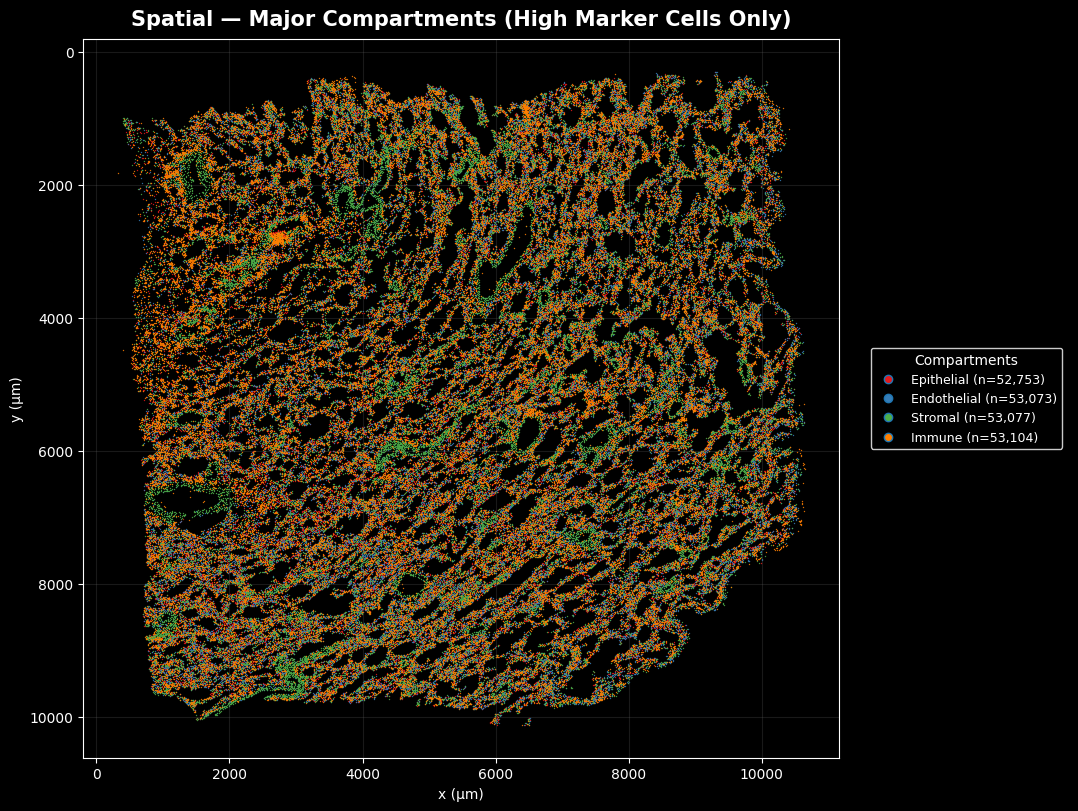

In [10]:
# ===============================================
# Figure 10 — Spatial: Major Cell Compartments (high marker score only)
# ===============================================
from matplotlib.lines import Line2D
from scipy.sparse import issparse

# Marker panels
marker_panels = {
    "Epithelial": ["AGER","PDPN","CAV1","SFTPC","SFTPA1","SFTPA2","SLC34A2","ABCA3",
                   "KRT5","TP63","SCGB1A1","MUC5AC","MUC5B"],
    "Endothelial": ["PECAM1","CLDN5","VWF","KDR","EMCN","CA4","EDNRB","LYVE1","PROX1"],
    "Stromal": ["COL1A1","COL1A2","COL3A1","LUM","DCN","PDGFRA","ACTA2","TAGLN",
                "MYH11","PDGFRB","RGS5","CSPG4"],
    "Immune": ["PTPRC","CD3D","CD3E","TRAC","CD4","CD8A","MS4A1","CD79A","MZB1",
               "MRC1","MARCO","LYZ","MS4A7","NKG7","GNLY","KLRD1"],
}

# Data
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

# Compute scores (mean across available genes) -> ALWAYS 1-D ndarray
scores = {}
for comp, genes in marker_panels.items():
    valid = [g for g in genes if g in adata.var_names]
    if not valid:
        continue
    subX = adata[:, valid].X
    if issparse(subX):
        s = np.asarray(subX.mean(axis=1)).ravel()   # sparse -> ndarray (n,)
    else:
        s = np.asarray(subX).mean(axis=1).ravel()   # dense -> ndarray (n,)
    scores[comp] = s

# Threshold high-signal cells (e.g., top 25% per compartment)
high_idx = {}
for c, s in scores.items():
    # ensure 1-D float array for quantile
    s1d = np.asarray(s, dtype=float).ravel()
    thr = np.quantile(s1d, 0.75)
    high_idx[c] = (s1d > thr)

# Palette
colors = {"Epithelial": "#e41a1c", "Endothelial": "#377eb8",
          "Stromal": "#4daf4a", "Immune": "#ff7f00"}

# ---- Figure with legend on the right ----
fig = plt.figure(figsize=(10.8, 8.0), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.26])
ax = fig.add_subplot(gs[0, 0])
leg_ax = fig.add_subplot(gs[0, 1]); leg_ax.axis("off")

proxies, labels = [], []
for comp in ["Epithelial", "Endothelial", "Stromal", "Immune"]:
    if comp not in high_idx:   # skip compartments with no valid markers
        continue
    idx = high_idx[comp]
    if np.any(idx):
        ax.scatter(x[idx], y[idx], s=1.0, c=colors[comp], lw=0, alpha=0.85, rasterized=True)
        proxies.append(Line2D([0], [0], marker="o", lw=0,
                              markerfacecolor=colors[comp], markersize=6))
        labels.append(f"{comp} (n={int(idx.sum()):,})")

# Style
ax.invert_yaxis()
ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)", color="white")
ax.set_ylabel("y (µm)", color="white")
ax.set_title("Spatial — Major Compartments (High Marker Cells Only)",
             fontsize=15, weight="bold", color="white", pad=10)

leg = leg_ax.legend(proxies, labels, title="Compartments",
                    loc="center left", frameon=True, fontsize=9)
leg_ax.set_facecolor("black")
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts():
    t.set_color("white")

fig.savefig(FIGS / "10_spatial_compartments_high.png", dpi=600, bbox_inches="tight")
plt.show(); plt.close(fig)
